<a href="https://colab.research.google.com/github/Tonge-Shim/pytorchstudy/blob/main/chap8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#unsqueeze


```
x = torch.tensor([1, 2, 3, 4])
torch.unsqueeze(x, 0)
tensor([[ 1,  2,  3,  4]])
torch.unsqueeze(x, 1)
tensor([[ 1],
        [ 2],
        [ 3],
        [ 4]])
```




In [ ]:
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
from PIL import Image

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [ ]:
import torch
from torchvision import datasets
data_path = '/content/sample_data'#location where the data will be downloaded
cifar10 = datasets.CIFAR10(data_path, train=True, download = True)
cifar10_val = datasets.CIFAR10(data_path, train = False, download = True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F84A910A810>,
 1,
 'automobile')

In [ ]:
from torchvision import transforms

In [ ]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download = False, transform = transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download = False, transform = transforms.ToTensor())
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in tensor_cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [ ]:
conv = nn.Conv2d(3, 16, kernel_size = 3)

In [ ]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

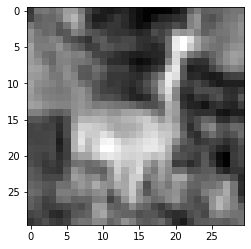

In [ ]:
plt.imshow(output[0, 0].detach(), cmap = 'gray')
plt.show()
#lost a few pixels in the process
#당연하지 커널 크기가 3이니까..

In [ ]:
#padding
conv =  nn.Conv2d(3, 1, kernel_size = 3, padding = 1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

first, zero out bias, just to remove any confounding(혼란스러운) factors, and then set weights to a constant value so that each pixel in the output gets the mean of its neighbors.

In [ ]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

In [ ]:
##conv.weight.one_() would result in each pixel in the output being the sum of the pixels in the neighborhood.the values in the output image would have been nine times larger.

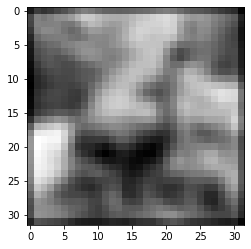

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap = 'gray')
plt.show()

In [ ]:
#edge detection kernel
conv = nn.Conv2d(3, 1, kernel_size = 3, padding = 1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

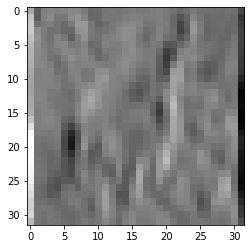

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap = 'gray')
plt.show()

#how are our networks going to be equipped to see those patterns with larger scope?

> use large convolution kernels

> used in convolutional neural networks, is stacking one convolution after the other and at the same time downsampling the image between successive convolutions.

#Downsampling

> average the four pixels

> take the maximum of the four pixels: maxpooling, currently the most commonly used approach, but has a downside of discarding the other 3-quarters of the data.

> perform a strided convolution, where only every Nth pixel is calculated

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [ ]:
numel_list = [p.numel() for p in model.parameters()] 
sum(numel_list), numel_list

NameError: ignored

pytorch allows us to use any computation in our model by subclassing nn.Module

 by writing the forward function explicitly, we can manipulate the output of self.pool3 directly and call view on it to turn it into a B × N vector

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) 
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) 
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x))) 
        out = self.pool2(self.act2(self.conv2(out))) 
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()
numel_list = [p.numel() for p in model.parameters()] 
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) 
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) 
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) 
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out  



In [ ]:
model = Net() 
model(img.unsqueeze(0))

In [ ]:
#saving model
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')